# Online Shoppers Final Report

### Group 24

**Members:**  
Andrew Liu, Audra Cornick, Haoxi Jiang, Nazia Chowdhury

#### STAT 301 - 5th December 2025

In [1]:
library(tidyverse)
library(car)       
library(glmnet)     
library(caret)      
library(readr)
library(dplyr)
library(broom)
library(cowplot)
library(ggplot2)
library(patchwork)
library(gridExtra)
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:pu

## Introduction

In the e-commerce industry, being able to predict whether a customer is likely to make a purchase is essential for designing effective recommendation systems, targeted marketing strategies, and personalized user experiences (Ding et al., 2015; Rajamma et al., 2009). Unlike in physical retail settings where sales associates can rely on experience, intuition, and real-time interactions to guide customers, online platforms must rely entirely on algorithmic decision-making (Moe, 2003). This creates a strong need for data-driven models that can identify which aspects of a user’s browsing behaviour are most informative for predicting the likelihood of a purchase.

Online shopping datasets often contain many behavioural, timing, and session-related variables, which can complicate traditional regression modeling due to multicollinearity and the inclusion of weak or redundant predictors. Logistic regression remains a standard, interpretable approach for predicting binary outcomes, while regularization techniques such as ridge regression can provide additional stability and improve predictive performance in the presence of multiple correlated variables.

**The guiding research question of this project is:**
 - Which combination of session-level, timing, and user/marketing features best predicts whether an online shopper completes a purchase, and how do model performance and interpretability differ between unpenalized logistic regression and ridge-penalized logistic regression?
 
Because the data come from naturally occurring online browsing sessions rather than a controlled experiment, it is not possible to draw causal conclusions about how specific variables influence purchasing behaviour. For this reason, our research question is intentionally focused on *prediction* and feature importance rather than estimating the effect of any individual variable.

This predictive approach mirrors existing work in e-commerce analytics, where retailers commonly use machine-learning–based recommendation systems, clickstream models, and regularized regression techniques to forecast customer actions and personalize online experiences (Chen, 2025; Narvekar & Banu, 2015; Satu & Islam, 2023). By comparing unpenalized logistic regression with ridge regression, we examine trade-offs between interpretability and predictive accuracy to determine the best models for predicting the probability of a customer making an online purchase. 

## Method and Results

### a) Data

In [2]:
data_url <- "https://raw.githubusercontent.com/audracornick/STAT301_Group24/main/online_shoppers_intention.csv"

OSPI <- read_csv(data_url)

head(OSPI)

Rows: 12330 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Month, VisitorType
dbl (14): Administrative, Administrative_Duration, Informational, Informatio...
lgl  (2): Weekend, Revenue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Administrative Administrative_Duration Informational Informational_Duration
1 0              0                       0             0                     
2 0              0                       0             0                     
3 0              0                       0             0                     
4 0              0                       0             0                     
5 0              0                       0             0                     
6 0              0                       0             0                     
  ProductRelated ProductRelated_Duration BounceRates ExitRates PageValues
1  1               0.000000              0.20000000  0.2000000 0         
2  2              64.000000              0.00000000  0.1000000 0         
3  1               0.000000              0.20000000  0.2000000 0         
4  2               2.666667              0.05000000  0.1400000 0         
5 10             627.500000              0.02000000  0.0500000 0         
6 19             154.216667              0.01578947  0.0245614 0         
  SpecialDay Month OperatingSystems Browser Region TrafficType
1 0          Feb   1                1       1      1          
2 0          Feb   2                2       1      2          
3 0          Feb   4                1       9      3          
4 0          Feb   3                2       2      4          
5 0          Feb   3                3       1      4          
6 0          Feb   2                2       1      3          
  VisitorType       Weekend Revenue
1 Returning_Visitor FALSE   FALSE  
2 Returning_Visitor FALSE   FALSE  
3 Returning_Visitor FALSE   FALSE  
4 Returning_Visitor FALSE   FALSE  
5 Returning_Visitor  TRUE   FALSE  
6 Returning_Visitor FALSE   FALSE

<b> Source : <br>
Sakar, C. & Kastro, Y. (2018). Online Shoppers Purchasing Intention Dataset [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q. <br>



- The dataset our group will be working on contains information from an observational study on individuals' e-commerce browsing sessions and whether their session ended with a purchase.
- There are a total of 12330 observations made where each row/observation is one session.
- There are a total of 18 columns where each column - excluding Revenue - falls into one of the five broader categories: <br>
          1. Type of website visited: Administrative, Informational, ProductRelated <br>
          2. Duration spent on website: Administrative_Duration, Informational_Duration, ProductRelated_Duration <br>
          3. Engagement metrics: BounceRates, ExitRates, PageValues <br>
          4. Timing & Season: SpecialDay, Month, Weekend <br>
          5 Technical data: Operating Systems, Browser, Region, TrafficType, VisitorType <br>

According to the creators, the dataset was formed so that each session/observation belonged to a different user and was obtained over the period of 1 year to avoid biases such as tendency to a specific campaign, special day, user profile, or period.

The following methods were used to collect data for each of the variables: 
- For the variables that we previously identified under the categories "Type of website visited" and "Duration spent on website", the values were derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another.
- For the variables that we previously identified under "Engagement metrics", the values were derived from Google Analytics measures. Specific definitions provided for variables included:
    - BounceRate: % of session that were a single-page view. 
    - ExitRate: % of pageviews for a page that were the last in a session. 
    - Page value: average monetary value attributed to pages viewed before a transaction.
- For variables under "Season& Timings" specific definitions provided were:
    - Special Day: a 0–1 proximity score to retail events, non-zero only within a defined window around the event, peaking on a specified date.    
- For the variables under Technical data - OperatingSystems, Browser, Region, TrafficType, VisitorType - aptured from session/analytics metadata; collection details not specified (NA).

### b) Exploratory Data Analysis 

The following table shows the type of data used to represent each of the variables and also indicates if there are any missing data for each of them. 

In [3]:
##Checking variable description
var_types <- data.frame(
  variable = names(OSPI),
  type = sapply(OSPI, function(x) class(x)[1]),
  missing = sapply(OSPI, function(x) sum(is.na(x))),
  row.names = NULL
)
var_types

variable                type      missing
1  Administrative          numeric   0      
2  Administrative_Duration numeric   0      
3  Informational           numeric   0      
4  Informational_Duration  numeric   0      
5  ProductRelated          numeric   0      
6  ProductRelated_Duration numeric   0      
7  BounceRates             numeric   0      
8  ExitRates               numeric   0      
9  PageValues              numeric   0      
10 SpecialDay              numeric   0      
11 Month                   character 0      
12 OperatingSystems        numeric   0      
13 Browser                 numeric   0      
14 Region                  numeric   0      
15 TrafficType             numeric   0      
16 VisitorType             character 0      
17 Weekend                 logical   0      
18 Revenue                 logical   0

In [4]:
OSPI_clean <- OSPI %>%
  filter(Region != 1) %>%
  mutate(
    Revenue = as.factor(Revenue),
    Month = as.factor(Month),
    VisitorType = as.factor(VisitorType),
    Weekend = as.factor(Weekend),
    SpecialDay = as.factor(SpecialDay),
    Browser = as.factor(Browser),
    TrafficType = as.factor(TrafficType),
    OperatingSystems = as.factor(OperatingSystems),
    Region         = as.factor(Region)
  ) %>%
  drop_na()
head(OSPI_clean)

Administrative Administrative_Duration Informational Informational_Duration
1 0              0                       0             0                     
2 0              0                       0             0                     
3 0              0                       0             0                     
4 0              0                       0             0                     
5 0              0                       0             0                     
6 0              0                       0             0                     
  ProductRelated ProductRelated_Duration BounceRates ExitRates  PageValues
1  1               0.000000              0.20000     0.20000000 0         
2  2               2.666667              0.05000     0.14000000 0         
3  1               0.000000              0.20000     0.20000000 0         
4  2              37.000000              0.00000     0.10000000 0         
5  3             395.000000              0.00000     0.06666667 0         
6 16             407.750000              0.01875     0.02583333 0         
  SpecialDay Month OperatingSystems Browser Region TrafficType
1 0          Feb   4                1       9      3          
2 0          Feb   3                2       2      4          
3 0.4        Feb   2                4       3      3          
4 0.8        Feb   2                2       2      3          
5 0          Feb   1                1       3      3          
6 0.4        Feb   1                1       4      3          
  VisitorType       Weekend Revenue
1 Returning_Visitor FALSE   FALSE  
2 Returning_Visitor FALSE   FALSE  
3 Returning_Visitor FALSE   FALSE  
4 Returning_Visitor FALSE   FALSE  
5 Returning_Visitor FALSE   FALSE  
6 Returning_Visitor FALSE   FALSE

In the following section, we will use visualisations to investigate the association between the explanatory variables with response.

`summarise()` has grouped output by 'Duration_Level'. You can override using
the `.groups` argument.
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 464 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 5844 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


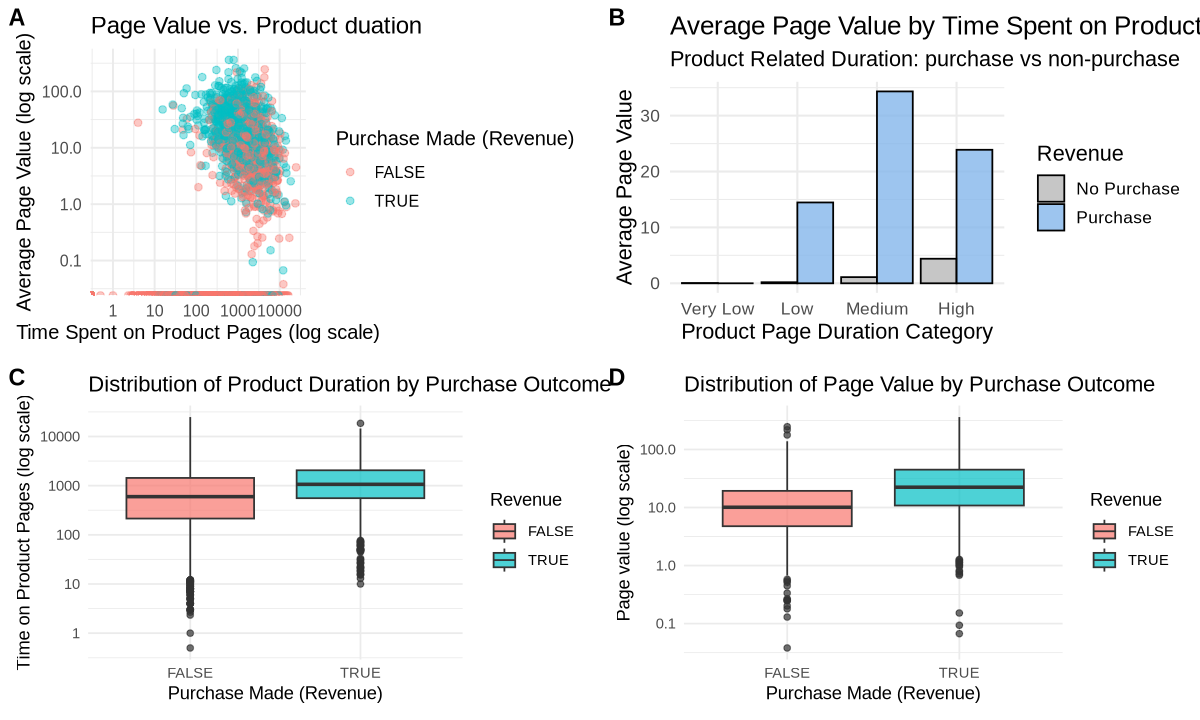

In [5]:
options(repr.plot.width = 10, repr.plot.height = 6)
# Visualization: relationship among PageValues, ProductRelated_Duration, and Revenue
p1<- ggplot(OSPI_clean , aes(x = ProductRelated_Duration,
                 y = PageValues,
                 color = Revenue)) +
  geom_point(alpha = 0.4, size = 1.8)+
  scale_x_log10() +
  scale_y_log10() +
  labs(
    title = "Page Value vs. Product duation",
    x = "Time Spent on Product Pages (log scale)",
    y = "Average Page Value (log scale)",
    color = "Purchase Made (Revenue)"
  ) +
  theme_minimal(base_size = 12)


OSPI2 <- OSPI_clean%>% mutate(
    Duration_Level = cut(
      ProductRelated_Duration,
      breaks = c(0, 10, 100, 1000, max(ProductRelated_Duration, na.rm = TRUE)),
      labels = c("Very Low", "Low", "Medium", "High"),
      include.lowest = TRUE
    )
  )

# Summarize PageValue by Duration bins
summary_df <- OSPI2%>%
  group_by(Duration_Level, Revenue) %>%
  summarise(
    MeanPageValue = mean(PageValues, na.rm = TRUE),
    n = n()
  )
# Plot the histogram (bar chart)
p2 <- ggplot(summary_df, aes(x = Duration_Level, y = MeanPageValue, fill = Revenue)) +
  geom_col(position = "dodge", color = "black", alpha = 0.8) +
  scale_fill_manual(values = c("#B8B8B8", "#84B6EB"), labels = c("No Purchase", "Purchase")) +
  labs(
    title = "Average Page Value by Time Spent on Product Pages",
    subtitle = "Product Related Duration: purchase vs non-purchase",
    x = "Product Page Duration Category",
    y = "Average Page Value",
    fill = "Revenue"
  ) +
  theme_minimal(base_size = 13)

p3 <- ggplot(OSPI_clean, aes(x = Revenue, y = ProductRelated_Duration, fill = Revenue)) +
  geom_boxplot(alpha = 0.7) +
scale_y_log10()+
  labs(title = "Distribution of Product Duration by Purchase Outcome",
       x = "Purchase Made (Revenue)", y = "Time on Product Pages (log scale)") +
  theme_minimal()

p4<-ggplot(OSPI_clean, aes(x = Revenue, y = PageValues, fill = Revenue)) +
  geom_boxplot(alpha = 0.7) +
scale_y_log10()+
  labs(title = "Distribution of Page Value by Purchase Outcome",
       x = "Purchase Made (Revenue)", y = "Page value (log scale)") +
  theme_minimal()

p1 <- p1 + theme(plot.margin = margin(10, 10, 10, 10))
p2 <- p2 + theme(plot.margin = margin(10, 10, 10, 10))
p3 <- p3 + theme(plot.margin = margin(10, 10, 10, 10))
p4 <- p4 + theme(plot.margin = margin(10, 10, 10, 10))
# Create top and bottom rows
top_row <- plot_grid(p1, p2, labels = c("A", "B"), ncol = 2, rel_widths = c(1, 1))
bottom_row <- plot_grid(p3, p4, labels = c("C", "D"), ncol = 2, rel_widths = c(1, 1))

# Combine into a 2x2 layout
final_plot_2x2 <- plot_grid(
  top_row,
  bottom_row,
  ncol = 1,
  rel_heights = c(1, 1)   # balance top and bottom rows equally
)

final_plot_2x2

#### <mark> Shorter interpretation on the visualization plot? </mark> 

#### Pre-selected variables reasoning 
For this project we will be dropping the following variables:
   - Operating System — no clear, consistent link to buying;
   - Region — It’s just a numeric code with no map/explanation, so we can’t interpret it reliably.
   - Bounce Rate — Overlaps with page counts/durations (single-page sessions), so it’s redundant. <br>
With the help of visualisations illustrated above, we further want to focus on the purchase outcomes of product pages and hence decide to drop the following variables: 
   - Informational:
   - Informational Duration:
   - Administrative:
   - Administrative Duration: 

<b> <mark>  Add another visualisation ..... </mark>  </b>  

### c) Methods: plan

#### Goals and Outcome:
   - Our goal is to understand which online session characteristics are associated with whether a user makes a purchase (Revenue = 1) or not (Revenue = 0).
   - Because the response is binary, we use logistic regression with a logit link. This lets us model the log-odds of purchase and interpret effects through odds ratios. 

#### Modelling framework and nested models: 
In the following section we fit a sequence of 4 nested logistic regression models to build up complexity in conceptually meaningful “blocks”:
1. Null model (model_null): Revenue ~ 1 (Baseline model assuming the same purchase probability for all sessions.)
2. Engagement model (model_eng): Revenue ~ PageValues + ProductRelated + ExitRates
      - Captures how on-site engagement and page value are related to purchase.)
3. Engagement + timing model (model_eng_time): Revenue ~ PageValues + ProductRelated + ExitRates + Month + Weekend +    SpecialDay
      - Adds possible seasonal and timing effects (month of visit, weekends, special days).
4. Full model (model_full): Revenue ~ PageValues + ProductRelated + ExitRates + Month + Weekend + SpecialDay + VisitorType + TrafficType + Browser
      - Adds contextual information about who the visitor is and how they reached the site.

In [6]:
# Null model (intercept only)
model_null <- glm(
  Revenue ~ 1,
  data = OSPI_clean,
  family = "binomial"
)

# Model 1: engagement only
model_eng <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates,
  data = OSPI_clean,
  family = "binomial"
)

# Model 2: engagement + timing
model_eng_time <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay,
  data = OSPI_clean,
  family = "binomial"
)

# Model 3: engagement + timing + context 
model_full <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data = OSPI_clean,
  family = "binomial"
)

anova(model_null, model_eng, model_eng_time, model_full, test = "Chisq")

Resid. Df Resid. Dev Df Deviance   Pr(>Chi)    
1 7549      6398.498   NA         NA           NA
2 7546      4507.330    3 1891.16714 0.000000e+00
3 7531      4361.081   15  146.24931 1.338015e-23
4 7499      4311.934   32   49.14742 2.688674e-02

#### Model Selection
The deviance table shows:

- Going from the null model to the engagement model reduces residual deviance by about 1891 on 3 degrees of freedom, with p-value ≈ 0.0000. This is an enormous and highly significant improvement, so engagement variables clearly explain a large amount of variation in Revenue.

- Adding timing variables (Month, Weekend, SpecialDay) reduces deviance by another ≈146 on 15 df, again with an extremely small p-value (≈ 1.3 × 10⁻²³). This shows that calendar effects and “special day” proximity have a statistically strong impact on purchase probability.

- Finally, adding VisitorType, TrafficType, and Browser reduces deviance by about 49 on 32 df, with p ≈ 0.027. The improvement is smaller than the previous jumps, but still statistically significant at the 5% level.

Since each step leads to a significant drop in deviance, the likelihood-ratio tests systematically reject the simpler models in favour of the more complex ones. For this reason we select the full model as our primary model: it captures the major explanatory structure (engagement + timing) and also keeps the additional user/marketing information that still provides a significant improvement in fit.

#### Model Diagnostic

In [7]:
#Checking multicollinearity
vif_values <- vif(model_full)
vif_values

GVIF     Df GVIF^(1/(2*Df))
PageValues     1.070396  1 1.034599       
ProductRelated 1.177025  1 1.084908       
ExitRates      1.193742  1 1.092585       
Month          2.002097  9 1.039320       
Weekend        1.067781  1 1.033335       
SpecialDay     1.362298  5 1.031400       
VisitorType    2.673435  2 1.278696       
TrafficType    2.649057 18 1.027431       
Browser        3.009321 12 1.046975

All adjusted VIF values are close to 1 (roughly between 1.0 and 1.3 for all variables, including Month, VisitorType, TrafficType and Browser), which is well below common concern thresholds (e.g., 2 or 5). This indicates that multicollinearity is mild in our selected predictors, so the logistic regression coefficients are reasonably stable and interpretable.

### d) Code and results

In [8]:
set.seed(123)

# Split into training (80%) and testing (20%)
train_index <- createDataPartition(OSPI_clean$Revenue, p = 0.8, list = FALSE)
train_data <- OSPI_clean[train_index, ]
test_data  <- OSPI_clean[-train_index, ]

# Create model matrices for glmnet (numeric inputs)
x_train <- model.matrix(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data = train_data
)[, -1]

x_test <- model.matrix(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data = test_data
)[, -1]

y_train <- as.numeric(train_data$Revenue) - 1
y_test  <- as.numeric(test_data$Revenue) - 1

In [9]:
glm_fit <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data   = train_data,
  family = "binomial"
)

glm_tidy <- tidy(glm_fit, exponentiate = TRUE) 

# Rank predictors by p-value (smallest = "most significant")
ranked_by_p <- glm_tidy %>%
  arrange(p.value) %>%                   # ascending p-value
  mutate(
    rank = row_number()
  )

ranked_by_p

term                         estimate     std.error    statistic   
1  PageValues                   1.085946e+00 3.546553e-03 23.248446824
2  ExitRates                    1.795673e-07 2.279834e+00 -6.813091987
3  (Intercept)                  1.762824e-01 2.935202e-01 -5.913284003
4  ProductRelated               1.003417e+00 8.931052e-04  3.818950767
5  MonthDec                     4.781367e-01 2.652232e-01 -2.782028452
6  TrafficType8                 1.958099e+00 2.548173e-01  2.637082613
7  MonthMar                     5.491502e-01 2.617945e-01 -2.289518317
8  TrafficType3                 6.740499e-01 1.775631e-01 -2.221469634
9  TrafficType13                5.636289e-01 2.653308e-01 -2.160921646
10 MonthMay                     6.549428e-01 2.485289e-01 -1.702849577
11 WeekendTRUE                  1.186900e+00 1.034493e-01  1.656314088
12 TrafficType20                1.812505e+00 3.783436e-01  1.571877343
13 MonthNov                     1.437870e+00 2.378444e-01  1.526891724
14 MonthFeb                     3.188789e-01 8.107329e-01 -1.409766363
15 TrafficType6                 7.110359e-01 2.785298e-01 -1.224401658
16 VisitorTypeReturning_Visitor 8.582991e-01 1.318572e-01 -1.158849354
17 MonthJune                    6.341437e-01 4.088728e-01 -1.113988689
18 Browser12                    3.833710e+00 1.338339e+00  1.004105413
19 TrafficType10                1.240106e+00 2.374102e-01  0.906435180
20 TrafficType11                1.322252e+00 3.107575e-01  0.898887957
21 SpecialDay1                  5.818551e-01 6.099497e-01 -0.887833481
22 Browser5                     1.233602e+00 2.424092e-01  0.866050579
23 Browser13                    4.279141e-01 1.003296e+00 -0.846044629
24 TrafficType4                 8.540576e-01 1.911698e-01 -0.825217414
25 Browser3                     5.741847e-01 7.299633e-01 -0.760043880
26 SpecialDay0.4                7.296513e-01 4.506342e-01 -0.699433268
27 SpecialDay0.8                7.481470e-01 4.237624e-01 -0.684713349
28 TrafficType9                 4.306999e-01 1.264344e+00 -0.666229907
29 Browser10                    1.247103e+00 3.536870e-01  0.624347567
30 SpecialDay0.6                1.228921e+00 3.537206e-01  0.582765692
31 Browser4                     1.121535e+00 2.008953e-01  0.570934819
32 TrafficType14                4.416909e-01 1.446361e+00 -0.564966002
33 TrafficType7                 1.336499e+00 6.803227e-01  0.426346811
34 TrafficType5                 8.703954e-01 3.263487e-01 -0.425335645
35 SpecialDay0.2                1.147442e+00 4.188764e-01  0.328343862
36 Browser7                     8.186475e-01 6.743480e-01 -0.296733557
37 Browser8                     1.131137e+00 4.541449e-01  0.271330603
38 MonthJul                     1.078986e+00 3.071397e-01  0.247514765
39 MonthSep                     9.453650e-01 2.944213e-01 -0.190829280
40 Browser6                     1.061376e+00 3.965030e-01  0.150228544
41 Browser2                     9.838275e-01 1.222314e-01 -0.133392030
42 VisitorTypeOther             9.507439e-01 8.148630e-01 -0.061986530
43 MonthOct                     1.016206e+00 2.840931e-01  0.056588705
44 TrafficType2                 1.007404e+00 1.308309e-01  0.056383561
45 TrafficType15                3.233534e-06 3.186634e+02 -0.039671751
46 TrafficType18                2.416181e-06 6.411190e+02 -0.020173044
47 TrafficType19                2.879472e-06 6.376773e+02 -0.020006834
48 Browser11                    1.708394e-06 1.001739e+03 -0.013256898
49 TrafficType16                1.763364e-06 1.455398e+03 -0.009102865
50 Browser9                     4.359896e-06 1.455398e+03 -0.008480887
51 TrafficType12                5.195955e-06 1.455398e+03 -0.008360348
   p.value       rank
1  1.474936e-119  1  
2   9.552302e-12  2  
3   3.353532e-09  3  
4   1.340205e-04  4  
5   5.402030e-03  5  
6   8.362246e-03  6  
7   2.204925e-02  7  
8   2.631917e-02  8  
9   3.070139e-02  9  
10  8.859622e-02 10  
11  9.765823e-02 11  
12  1.159790e-01 12  
13  1.267879e-01 13  
14 

Using the full logistic regression model with Revenue as the binary response, we find that several predictors are strongly associated with the probability that a session ends in a purchase:

- PageValues has a positive and highly significant coefficient. Holding all other variables fixed, sessions with higher PageValues (reflecting how much value the pages in the session carry) are more likely to convert. Intuitively, once users reach pages that are “closer” to a transaction, the odds of purchase increase.

- ProductRelated (number of product-related pages visited) also has a positive effect. Longer product-browsing sessions are associated with higher purchase odds, suggesting that users who spend time exploring products are more likely to buy than casual visitors.

- ExitRates has a negative coefficient: sessions that include pages with high exit rates are less likely to end in a purchase. This is consistent with the idea that if users spend time on “dead-end” pages where many people leave the site, they are more likely to drop off instead of buying.

- Calendar / timing variables (Month, Weekend, SpecialDay) jointly matter. The deviance test indicates that adding these dummies significantly improves model fit, which suggests that both seasonality (e.g., November vs. other months) and whether the session happens on a weekend or near a “special day” meaningfully change the chance of purchase.

- User / marketing variables (VisitorType, TrafficType, Browser) provide additional but smaller improvements. For example, returning visitors tend to have higher purchase odds than new visitors, and certain traffic sources (e.g., specific TrafficType categories) are more effective at driving purchases than others. These effects are generally weaker than the main engagement signals but still statistically detectable.

Overall, the key story from the GLM is: engagement with valuable and product-related pages is the strongest driver of purchases, while timing and user/traffic characteristics provide secondary refinements on top of that.

lambda.min (ridge) = 0.01732465 
lambda.1se  (ridge) = 0.04002219 


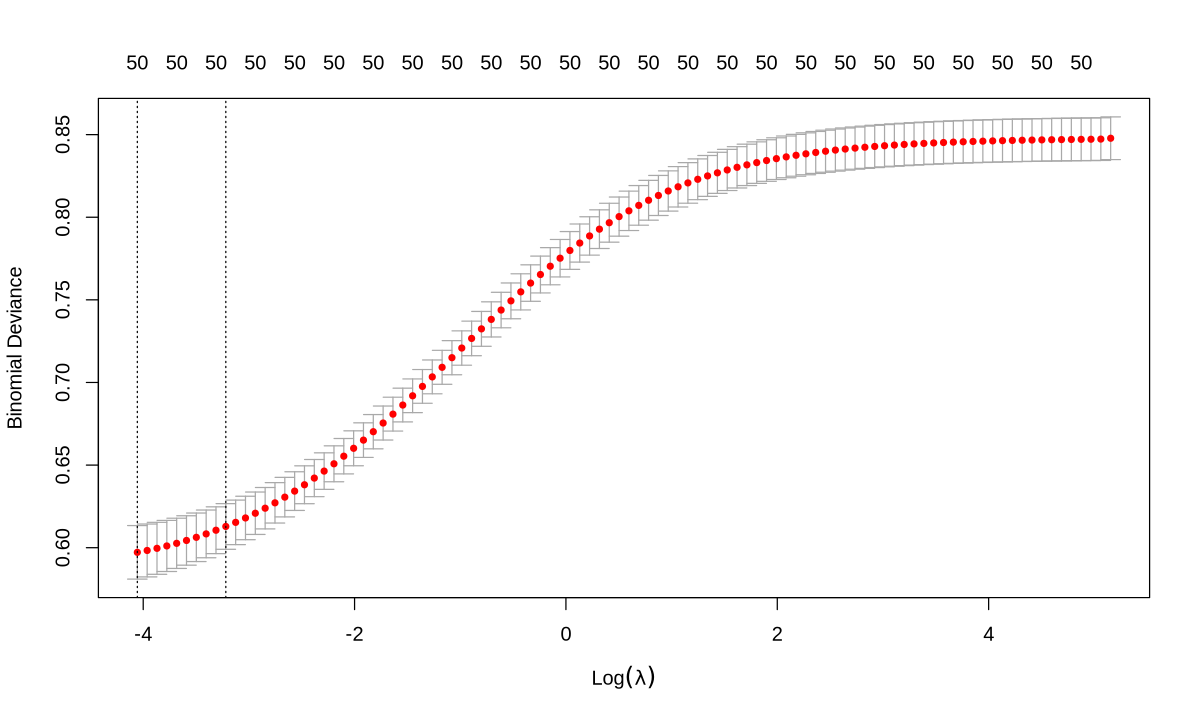

In [10]:
set.seed(123)

ridge_fit <- cv.glmnet(
  x_train, y_train,
  alpha = 0,               # 0 = RIDGE
  family = "binomial",
  type.measure = "deviance",
  nfolds = 10
)

# Inspect tuning
plot(ridge_fit)
cat("lambda.min (ridge) =", ridge_fit$lambda.min, "\n")
cat("lambda.1se  (ridge) =", ridge_fit$lambda.1se, "\n")

In [11]:
# Coefficients at lambda.min
coef(ridge_fit, s = "lambda.min")

51 x 1 sparse Matrix of class "dgCMatrix"
                                        s1
(Intercept)                  -1.9753509756
PageValues                    0.0604869571
ProductRelated                0.0038220601
ExitRates                    -9.3809766404
MonthDec                     -0.3974527841
MonthFeb                     -0.6193849488
MonthJul                      0.2030477833
MonthJune                    -0.2801638267
MonthMar                     -0.3159367367
MonthMay                     -0.1594793434
MonthNov                      0.4702275686
MonthOct                      0.2110842000
MonthSep                      0.1393848848
WeekendTRUE                   0.1297516255
SpecialDay0.2                 0.0834920197
SpecialDay0.4                -0.3299421980
SpecialDay0.6                 0.0230558080
SpecialDay0.8                -0.3766820889
SpecialDay1                  -0.5664998124
VisitorTypeOther             -0.2508794379
VisitorTypeReturning_Visitor -0.1902504374
TrafficType2

In [12]:
# Predicted probabilities on the test set
prob_test_glm <- predict(
  glm_fit,
  newdata = test_data,
  type   = "response"   # gives P(Revenue = 1 | X)
)

# Turn probabilities into class predictions with 0.5 cutoff
pred_test_glm <- ifelse(prob_test_glm > 0.5, 1, 0)

# Test accuracy
accuracy_glm <- mean(pred_test_glm == y_test)

prob_test_ridge <- predict(
  ridge_fit,
  newx = x_test,
  s = "lambda.min",
  type = "response"
)

pred_test_ridge <- ifelse(prob_test_ridge > 0.5, 1, 0)

# Test accuracy
accuracy_ridge <- mean(pred_test_ridge == y_test)
round(accuracy_glm, 3)
round(accuracy_ridge, 3)

[1] 0.89

[1] 0.885

- We compared a standard logistic regression model with a ridge-penalized logistic model using the same predictors. On our held-out test set, the unpenalized logistic regression achieved slightly higher classification accuracy (0.89 vs 0.88 for ridge).
- However, ridge regression directly optimizes deviance and provides more shrinkage of coefficients, which can improve stability in the presence of many dummy variables.

Since our predictor dimension is moderate and multicollinearity is not severe, the plain logistic model performs very competitively; we report its coefficients and p-values for interpretability, and use the ridge model mainly as a regularized benchmark for predictive performance.

In [13]:
# Confusion matrix for GLM logistic model
cm_glm <- confusionMatrix(
  data      = factor(pred_test_glm),
  reference = factor(y_test),
  positive  = "1"          # 1 = purchase
)

# Extract by-class metrics
m_glm <- cm_glm$byClass

metrics_glm <- c(
  precision = unname(m_glm["Pos Pred Value"]),
  recall    = unname(m_glm["Sensitivity"]),
  F1        = unname(m_glm["F1"])
)

cm <- confusionMatrix(
  data      = factor(pred_test_ridge),
  reference = factor(y_test),
  positive  = "1"          # 1 = purchase
)

# Extract the by-class metrics
m <- cm$byClass

metrics_ridge <- c(
  precision = unname(m["Pos Pred Value"]),
  recall    = unname(m["Sensitivity"]),
  F1        = unname(m["F1"])
)

signif(metrics_glm, 3)
signif(metrics_ridge, 3) 

precision    recall        F1 
    0.775     0.379     0.509

precision    recall        F1 
    0.812     0.304     0.442

#### Performance Evaluation
- Both models achieve high accuracy (≈ 0.88–0.89), which is much better than a trivial classifier that always predicts “no purchase” in this imbalanced dataset.

- The ridge model has slightly higher precision (≈ 0.81 vs 0.78): when it predicts a purchase, it is correct more often. However, it misses more positives.

- The GLM has noticeably higher recall (≈ 0.38 vs 0.30) and higher F1, meaning it finds more of the true purchase sessions, at the cost of a few more false positives.

Since our goal is to identify as many potential purchasers as possible while still keeping a reasonable precision, the higher recall and F1 of the full logistic regression model make it more attractive as the final model.

## Discussion

- Our analysis shows that on-site engagement is the main driver of purchases. Moving from the null to the engagement model produced a huge drop in deviance, and adding timing and user/marketing variables gave smaller but still significant improvements, so we selected the full logistic model.
- In this model, higher PageValues and more ProductRelated page views increase purchase odds, while higher ExitRates reduce them, and timing and visitor/traffic variables refine the predicted probabilities on top of these core engagement signals.

- Overall, these results are largely in line with expectations for an e-commerce setting: deeper product engagement and visits to high-value pages are associated with higher conversion, returning visitors convert more than new ones, and special-period timing matters.

- A few ways the model could be improved includes:
    - Adjusting the classification threshold or using a cost-sensitive approach could better reflect the trade-off between missing purchases and flagging non-buyers.
    - More systematic validation, such as k-fold cross-validation, would also give a more robust assessment of predictive performance.<br>


- This study suggests a few directions for future work including:
  - Using the model in real time to identify high-engagement sessions and testing targeted interventions (e.g., personalized offers) via A/B experiments.
  - Comparing models across campaigns, devices, or regions could help identify which marketing strategies and site designs are most effective at turning engaged visitors into customers.

## References 

Chen, X. (2025). Consumer online shopping behavior prediction based on machine learning algorithm. *Procedia Computer Science, 262*, 1395–1401. https://doi.org/10.1016/j.procs.2025.05.187

Ding, A. W., Li, S., & Chatterjee, P. (2015). Learning user real-time intent for optimal dynamic web page transformation. *Information Systems Research, 26*(2), 339–359. https://doi.org/10.1287/isre.2015.0568

Moe, W. W. (2003). Buying, searching, or browsing: Differentiating between online shoppers using in-store navigational clickstream. *Journal of Consumer Psychology, 13*(1–2), 29–39. https://doi.org/10.1207/S15327663JCP13-1&2_03

Narvekar, M., & Banu, S. S. (2015). Predicting user's web navigation behavior using hybrid approach. *Procedia Computer Science, 45*, 3–12. https://doi.org/10.1016/j.procs.2015.03.073

Rajamma, R. K., Paswan, A. K., & Hossain, M. M. (2009). Why do shoppers abandon shopping cart? Perceived waiting time, risk, and transaction inconvenience. *Journal of Product & Brand Management*, 18(3), 188-197. https://doi.org/10.1108/10610420910957816

Sakar, C. O., Polat, S., Katircioglu, M., & Kastro, Y. (2019). Real-time prediction of online shoppers’ purchasing intention using multilayer perceptron and LSTM recurrent neural networks. *Neural Computing & Applications*. https://doi.org/10.24432/C5F88Q

Satu, M. S., & Islam, S. F. (2023). Modeling online customer purchase intention behavior applying different feature engineering and classification techniques. *Discover Artificial Intelligence, 3*(36). https://doi.org/10.1007/s44163-023-00086-0